In [16]:
import itertools
import matplotlib.pyplot as plt

from jax import value_and_grad, jit, vmap, grad
from jax.experimental import optimizers as optim
import jax.numpy as jnp
import jax.nn as jnn
import jax.random as rand
import jax.scipy as jsp
from InverseAutoRegFlow import MCKLDiv, init_rand_param, variance_scaling, MakeFlow

In [97]:
mean = jnp.array([2., -2.])
var = jnp.array([[2, -1], [-1, 4]])
def log_lik (x1, x2):
    return jsp.stats.multivariate_normal.logpdf(jnp.array([x1, x2]), mean, var)

K = 1
hidden_layers = [(0,0)]
activations = [([None],[None])]

In [105]:
def log_lik (x1, x2): #banana
    return - 1./(2*8.) * (x2)**2 - 1./2. * (x1-1/4.*x2**2)**2

K = 2
hidden_layers = [(2,2), (2,2)]
activations = [([jnn.elu], [jnn.elu]), ([jnn.elu], [jnn.elu])]

In [114]:
def log_lik (x1, x2): #neal funnel
    return - 1./2 * (x1)**2 - x1 - 1./(2*jnp.exp(2.*x1)) * (x2)**2

K = 2
hidden_layers = [(2,2), (2,2)]
activations = [([jnn.elu], [jnn.elu]), ([jnn.elu], [jnn.elu])]

In [121]:
def log_lik (x1, x2): #bimodal
    mean1 = (x1+2.)**2 + (x2+2.)**2
    mean2 = (x1-2.)**2 + (x2-2.)**2
    return jnp.log( jnp.exp(-1./2.*mean1) + jnp.exp(-1./2.*mean2) )

K = 2
hidden_layers = [(2,2), (2,2)]
activations = [([jnn.elu], [jnn.elu]), ([jnn.elu], [jnn.elu])]

(-6.0, 6.0)

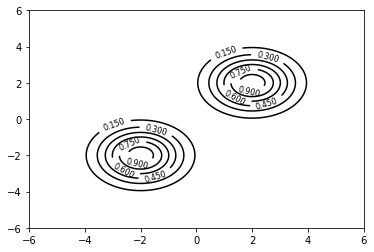

In [122]:
x1 = jnp.linspace(-6, 6, 1000)
x2 = jnp.linspace(-6, 6, 1000)
lik = lambda x1, x2: jnp.exp(log_lik(x1, x2))
lL = vmap(lik, (None, 0), 0)
lL = vmap(lL, (0, None), 1)
y = lL(x1, x2)
cnt = plt.contour(x1, x2, y, colors='black')
plt.clabel(cnt, inline=True, fontsize=8)
plt.xlim([-6, 6])
plt.ylim([-6, 6])

(-6.0, 6.0)

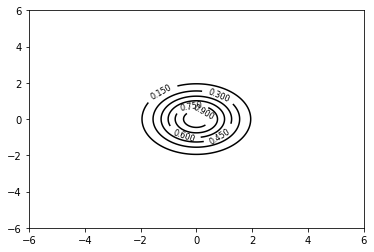

In [99]:
def uni_lik (x1, x2):
    return jnp.exp(-1./2.*(x1**2 + x2**2))
x1 = jnp.linspace(-6, 6, 1000)
x2 = jnp.linspace(-6, 6, 1000)
x1, x2 = jnp.meshgrid(x1, x2)
y = uni_lik(x1, x2)
cntu = plt.contour(x1, x2, y, colors='black')
plt.clabel(cntu, inline=True, fontsize=8)
plt.xlim([-6, 6])
plt.ylim([-6, 6])

In [123]:
loss = lambda param, Z: MCKLDiv(Z, param, activations, lambda x: log_lik(x[0], x[1]))

In [124]:
opt_init, opt_update, get_params = optim.adagrad(step_size = 0.9, momentum = 0.8)

In [125]:
@jit
def update (i, opt_state, Z):
    params = get_params(opt_state)
    KL, grad_params = value_and_grad(loss)(params, Z)
    return KL, opt_update(i, grad_params, opt_state)

In [126]:
params = init_rand_param(2, K, hidden_layers, rng = variance_scaling(1., "normal"))
opt_state = opt_init(params)
itercount = itertools.count()

In [127]:
kmm = rand.PRNGKey(123)
Z = rand.normal(kmm, (1000, 2))

In [128]:
another = True
while another:
    for e in range(10000):
        KL, opt_state = update(next(itercount), opt_state, Z)
        print("KL Divergence = {}".format(KL), end = "\r")
    yn = input('continue?')
    if yn != '':
        another = False

continue?nnce = 0.6558619737625122


In [129]:
def Ulik (x1, x2):
    x, ldj = MakeFlow(jnp.array([x1, x2]), get_params(opt_state), activations, True)
    return lik(x[0], x[1]) * jnp.exp(ldj)

(-6.0, 6.0)

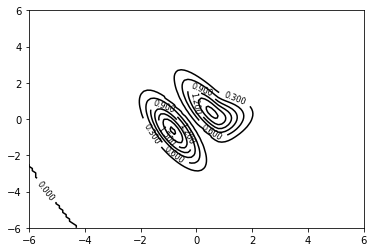

In [130]:
x1 = jnp.linspace(-6, 6, 100)
x2 = jnp.linspace(-6, 6, 100)
ul = vmap(Ulik, (None, 0), 0)
ul = jit(vmap(ul, (0, None), 1))
y = ul(x1, x2)
cnt = plt.contour(x1, x2, y, colors='black')
plt.clabel(cnt, inline=True, fontsize=8)
plt.xlim([-6, 6])
plt.ylim([-6, 6])